# Moving windows 

There are a number of ways to apply a function in a moving window. Here I review a couple of
ideas. I found that with low numbers of
data points simple for loops are more than sufficient, but the `pandas` implementation
is far easier and faster so should be used. If you have a lot of data, then it may be worth taking
the time to broadcast to a `numpy` array.

## Applying a function

The standard functions which are applied in a moving window are averages and
variances/std. As a result `pandas` has a built in method to handle this. To be
fair to all methods, we will test with a user-defined function: the 
[mean absolute deviation](http://en.wikipedia.org/wiki/Absolute_deviation#Mean_absolute_deviation_.28MAD.29_.28about_mean.29)

Lets get started by coding this function and some test data


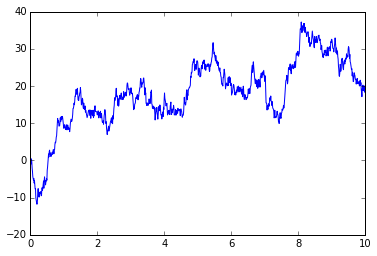

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# The user defined function we want to apply in a moving window
mad = lambda x: np.fabs(x - x.mean()).mean()

# Some random data
N = 1000
t = np.linspace(0, 10, N)
x = np.random.randn(N).cumsum()

# The moving window parameters
window_length = 300
window_shift = 1

# Plot the data
plt.plot(t, x)
plt.show()


## The for loop

The simplest, but slowest, method is obviously the good old `for` loop. Let's test this first

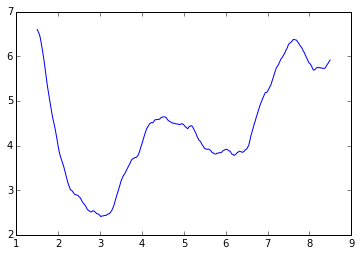

10 loops, best of 3: 40.2 ms per loop


In [53]:
def ForLoop(f):
    moving_val = []
    moving_time = []
    for i in xrange(0, N-window_length, window_shift):
        moving_val.append(f(x[i:i+window_length]))
        moving_time.append(np.average(t[i:i+window_length]))
    return moving_time, moving_val

plt.plot(*ForLoop(mad))
plt.show()
    
%timeit ForLoop(mad)

## Pandas `rolling_apply`

Next up is the inspiration for all this, `pandas.rolling_apply`. This is by far the easiest
method since it can be implemented in one line. However, as far as I can see there is no way
to set the window_shift

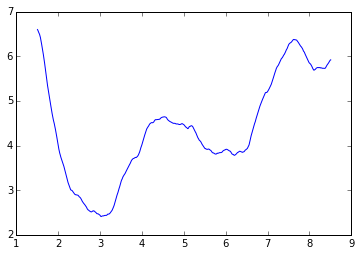

10 loops, best of 3: 26.2 ms per loop


In [54]:
out = pd.rolling_apply(x, window_length, mad, center=True)

plt.plot(t, out)
plt.show()

%timeit out = pd.rolling_apply(x, window_length, mad)

### Numpy broadcast to array

Next we will broadcast the 1D array to a 2D array, compute the function along 
the new axis. This will require some effort to rewrite the function so it 
handles the shapes correctly. For help in understanding how this is done I 
really recommend taking a look at [this scipy page](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) 

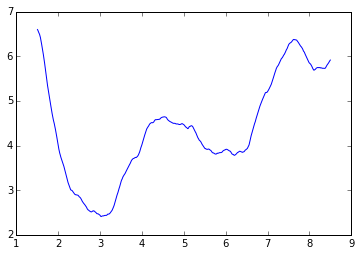

100 loops, best of 3: 11.4 ms per loop


In [55]:
def NumpyArray():

    mad_array = lambda x: np.fabs(x.T - x.mean(axis=1)).mean(axis=0)
    
    vert_idx_list = np.arange(0, N - window_length, window_shift)
    hori_idx_list = np.arange(window_length)
    A, B = np.meshgrid(hori_idx_list, vert_idx_list)
    idx_array = A + B 
    x_array = x[idx_array]

    return t[vert_idx_list+int(window_length/2.)], mad_array(x_array)

plt.plot(*NumpyArray())
plt.show()

%timeit NumpyArray()

## Additional

There is also a rolling apply function proposed by [Erik Rigtorp](http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html). I still don't really understand how this works, but there is useful discussions to be found [here](http://numpy-discussion.10968.n7.nabble.com/Rolling-window-moving-average-moving-std-and-more-td4744.html). I've not included because I could not get it to work. If you can see how to do this please let me know!